In [93]:
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
import matplotlib
import numpy as np
import cartopy.crs as ccrs
import glob
import os
import xarray as xr
import scipy.stats as stats
from matplotlib.colors import TwoSlopeNorm

In [16]:
#custom colormap
import pickle

# Load the colormap
with open("fog_colormap.pkl", "rb") as f:
    fog_cmap = pickle.load(f)

In [17]:
djf = ["DEC", "JAN", "FEB"]
mam = ["MAR", "APR", "MAY"] 
jja = ["JUN", "JUL", "AUG"]
son = ["SEP", "OCT", "NOV"]

seasons = [djf, mam, jja, son]

lat_bins = np.arange(-90, 91, 5)
lon_bins = np.arange(0, 361, 5)

lon_grid, lat_grid = np.meshgrid(lon_bins, lat_bins)

In [61]:
path = "data/EECRA/5yr_seasonal_study/"

files = os.listdir(path)

In [19]:
""" #explore one year
year = "1966"

fig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axs = axs.flatten()

for i, season in enumerate(seasons):
    seasonName = season[0][0]+season[1][0]+season[2][0]
    fn = "counts_"+seasonName+year+".csv"
    
    counts_probOccurance = pd.read_csv(path + fn, sep=',', header=None)
    masked = np.ma.masked_invalid(counts_probOccurance)
    
    ax = axs[i]
    cmap = fog_cmap
    cmap.set_bad('darkgray')

    img = ax.imshow(
        masked,
        extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],
        cmap=cmap,
        origin='lower',
        transform=ccrs.PlateCarree(),
        aspect='auto'
    )
    
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.7, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    ax.set_title(seasonName + " " + year)
    
# Colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
fig.colorbar(img, cax=cbar_ax, label='Fog Probability')"""


' #explore one year\nyear = "1966"\n\nfig, axs = plt.subplots(2, 2, figsize=(16, 8), subplot_kw={\'projection\': ccrs.PlateCarree(central_longitude=180)})\naxs = axs.flatten()\n\nfor i, season in enumerate(seasons):\n    seasonName = season[0][0]+season[1][0]+season[2][0]\n    fn = "counts_"+seasonName+year+".csv"\n\n    counts_probOccurance = pd.read_csv(path + fn, sep=\',\', header=None)\n    masked = np.ma.masked_invalid(counts_probOccurance)\n\n    ax = axs[i]\n    cmap = fog_cmap\n    cmap.set_bad(\'darkgray\')\n\n    img = ax.imshow(\n        masked,\n        extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],\n        cmap=cmap,\n        origin=\'lower\',\n        transform=ccrs.PlateCarree(),\n        aspect=\'auto\'\n    )\n\n    ax.coastlines()\n    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color=\'gray\', alpha=0.7, linestyle=\'--\')\n    gl.right_labels = False\n    gl.top_labels = False\n    ax.set_title(seasonName + " " + year)\n\n# Colorbar\nfig.subpl

Seasonal Climatology

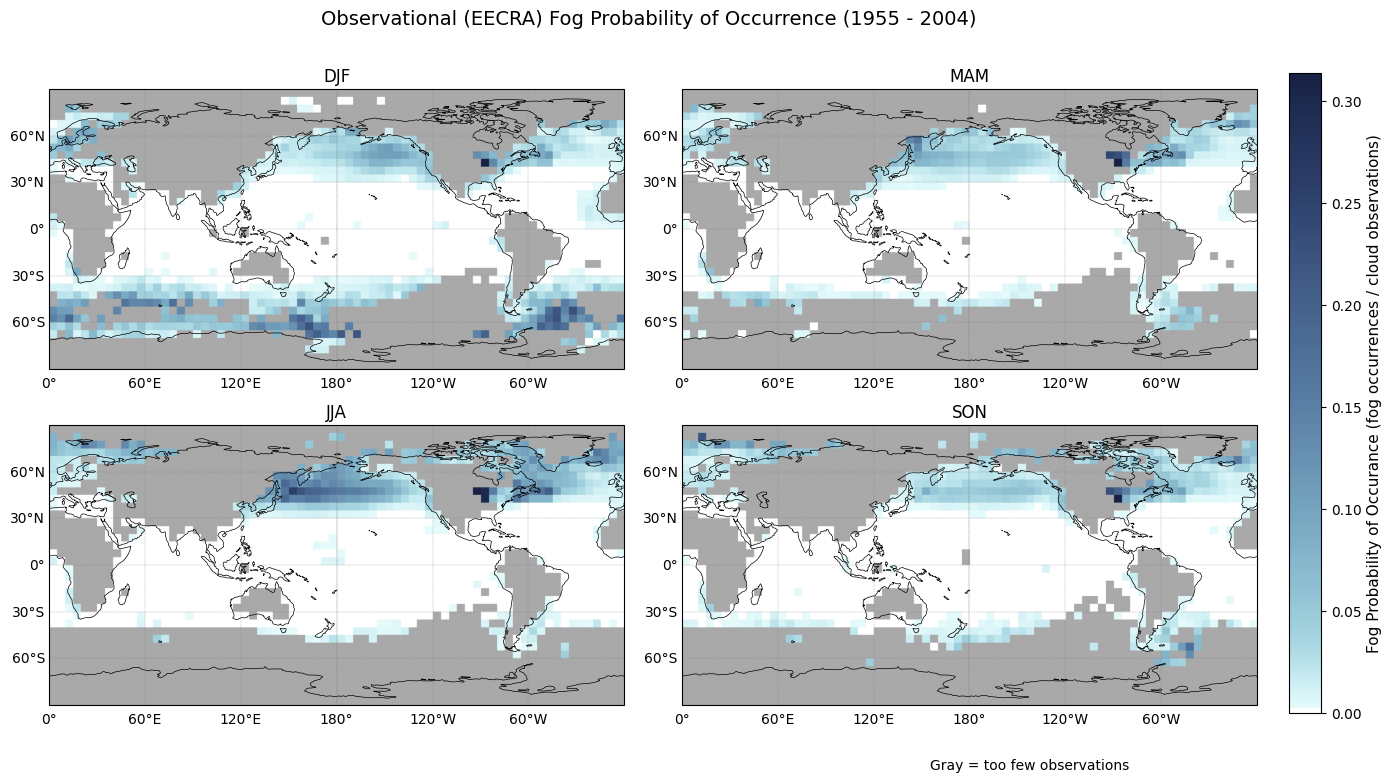

In [62]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw={'wspace': 0.1}, subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
axs = axs.flatten()

for i, season in enumerate(seasons):
    seasonName = season[0][0]+season[1][0]+season[2][0]
    
    # Get all files that match this season name
    season_files = glob.glob(os.path.join(path, f"*{seasonName}*.csv"))
    
    #get 3d array for all the yrs in season
    data_arrays = []
    for f in season_files:
        df = pd.read_csv(f, sep=',', header=None)
        da = xr.DataArray(df.values, dims=["lat", "lon"])
        data_arrays.append(da)

    stacked = xr.concat(data_arrays, dim="time")
    
    # Mask areas where there is not at least one fog probability value per every 10-15 yrs
    chunks = np.array_split(stacked, 4, axis=0) #chunks of years
    chunk_masks = [(~chunk.isnull()).any(dim='time') for chunk in chunks] #list of masks, areas where there was no observation during chunk
    combined_mask = xr.concat(chunk_masks, dim='chunk').all(dim='chunk') #combine masks

    climatology = stacked.mean(dim='time', skipna=True)
    climatology = climatology.where(combined_mask)
    
    ax = axs[i]
    cmap = fog_cmap
    cmap.set_bad('darkgray')

    img = ax.imshow(
        climatology,
        extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],
        cmap=cmap,
        origin='lower',
        transform=ccrs.PlateCarree(),
        aspect='auto'
    )
    
    ax.coastlines(linewidth=0.5)
    gl = ax.gridlines(draw_labels=True, linewidth=0.3, color='gray', alpha=0.7, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    ax.set_title(seasonName)
    
# Colorbar
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax = cbar_ax)
cbar.set_label("Fog Probability of Occurance (fog occurrences / cloud observations)", fontsize = 11)

fig.suptitle("Observational (EECRA) Fog Probability of Occurrence (1955 - 2004)", fontsize=14)
fig.text(0.8, 0.03, "Gray = too few observations", fontsize=10, ha="right")

plt.savefig("dataViz/EECRA_SeasonalClimatology")
plt.show()


Fog Trend Map

In [77]:
def linreg_slope(x, y):
    slope, intercept, r_value, p_value, _ = stats.linregress(x, y)
    return slope, intercept, r_value, p_value

### note: code is tightly coupled to 1955- 2004 being in the 5yr_seasonal_study folder

yearDAs = []
#seasonal 5yr filename years
for yr in range(1955, 2001, 5):
    #get mean of 5yr, where there have been observations in every season
    seasonalfiles = glob.glob(os.path.join(path, f"*{str(yr)}*.csv"))
    seasonal_das = []
    for f in seasonalfiles:
        df = pd.read_csv(f, sep=',', header=None)
        da = xr.DataArray(df.values, dims=["lat", "lon"])
        seasonal_das.append(da)
        
    stacked = xr.concat(seasonal_das, dim="time") 
    yearDA = stacked.mean("time", skipna=False) #mean fog probability across 5- yr file
    
    yearDAs.append(yearDA)

stacked = xr.concat(yearDAs, dim="time")
stacked_test1 = stacked.mean(dim="time")
time_x = list(range(1955, 2001, 5)) # TODO

# Mask areas where there is not at least one fog probability observation per every 10-15 yrs
chunks = np.array_split(stacked, 2, axis=0) #chunks of years
chunk_masks = [(~chunk.isnull()).any(dim='time') for chunk in chunks] #list of masks, areas where there was no observation during chunk
combined_mask = xr.concat(chunk_masks, dim='chunk').all(dim='chunk') #combine masks

stacked = stacked.where(combined_mask)
stacked_test2 = stacked.mean(dim="time")

results = xr.apply_ufunc( 
    linreg_slope,
    time_x,
    stacked,
    input_core_dims=[["time"], ['time']],
    output_core_dims=[[], [], [], []],
    vectorize=True,
    output_dtypes=[float, float, float, float],
)

slope, _, _, _ = results

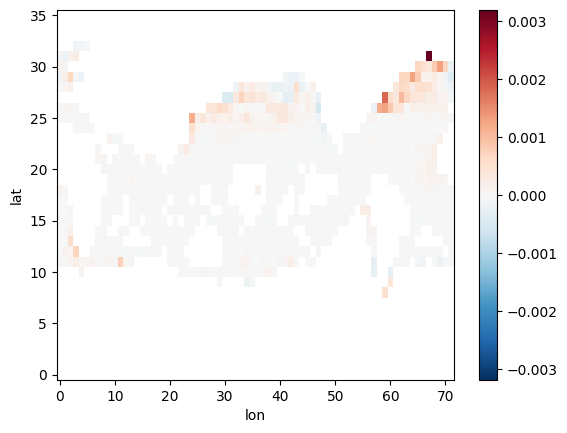

In [80]:
slope.plot()

Text(0.5, 1.0, 'EECRA Fog Trend Slope Map (1955 - 2004)')

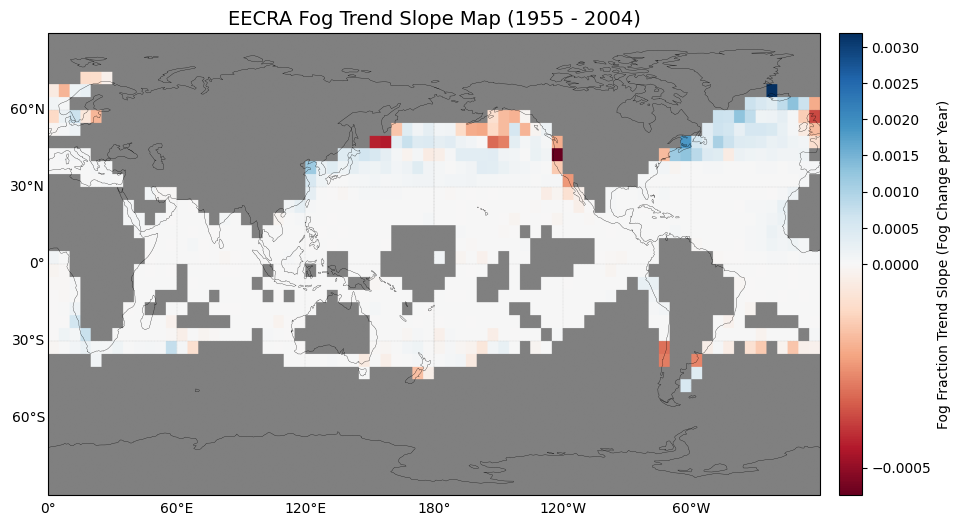

In [101]:
norm = TwoSlopeNorm(vmin=np.nanmin(slope), vcenter=0, vmax=np.nanmax(slope))

fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Add map features
ax.coastlines(linewidth=0.2)
gl = ax.gridlines(draw_labels=True, linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot data
masked_data = np.ma.masked_where(~combined_mask, slope) #getting mask to set to

# 2. Set the colormap "bad" color to gray
cmap = plt.get_cmap('RdBu')
cmap.set_bad(color="gray")

# 3. Plot using imshow with masked data
img = ax.imshow(
    slope,
    extent=[lon_bins[0], lon_bins[-1], lat_bins[0], lat_bins[-1]],
    cmap=cmap,
    norm=norm,
    origin='lower',
    transform=ccrs.PlateCarree(),
    aspect='auto'
)

# Colorbar
cbar = plt.colorbar(img, ax=ax, orientation='vertical', label='Fog Fraction Trend Slope (Fog Change per Year)', pad = 0.02)

plt.title('EECRA Fog Trend Slope Map (1955 - 2004)', fontsize=14)


In [ ]:
np.nanmin(slope)

np.float64(-0.0005674055405274212)